Generate mock Hyades data with DR2 uncertainties and fit with the full model.

In [2]:
%matplotlib inline
import os
import pandas as pd
import numpy as np
from astropy.table import Table
import astropy.units as u
import astropy.coordinates as coords
# plotting
import matplotlib.pyplot as plt
from matplotlib import colors
import arviz as az
import seaborn as sns
from corner import corner

# project
import pystan
import gapipes as gp
import kinesis as kn
print(f"pystan v{pystan.__version__}")
np.random.seed(18324)

pystan v2.19.1.1


In [2]:
out_full = pd.read_csv("../data/hyades_full.csv")
df = out_full.loc[out_full['in_dr2'] == True]
print(f'{len(df)} rows')

515 rows


In [3]:
def load_old_pickle(filename):
    import pickle
    with open(filename, "rb") as f:
        model, stanfit = pickle.load(f)
    return stanfit

fit_rv1 = load_old_pickle('../report/mock/T0_RV1_modelT1_0.fit')
azfit_rv1 = az.from_pystan(fit_rv1)

In [3]:
fit = kn.load_stanfit('../report/hyades-mock-fullmodel/fit.pickle')
fit_rvall = kn.load_stanfit('../report/hyades-mock-fullmodel/fit_rvall.pickle')
fit_ideal = kn.load_stanfit('../report/hyades-mock-fullmodel/fit_ideal.pickle')
# fit_ideal = kn.load_stanfit('../report/hyades-mock-fullmodel/fit_ideal_sigv1.pickle')

azfit = {'ref':az.from_pystan(fit),
         'rvall':az.from_pystan(fit_rvall),
         'ideal':az.from_pystan(fit_ideal)}
for v in azfit.values():
    for ck, cv in kn.decompose_T(v.posterior['T_param']).items():
        v.posterior[ck]=cv
#     v.posterior = v.posterior.assign_coords(it=lambda x:x.chain*len(x.draw)+x.draw)
#     v.posterior = v.posterior.stack(it=('chain','draw'))

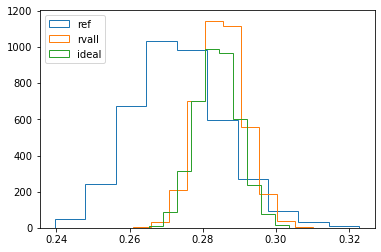

In [4]:
def sigvscale_to_sigv1d(x):
    return np.linalg.norm(x, axis=0)/np.sqrt(3)
for k, v in azfit.items():
    plt.hist(sigvscale_to_sigv1d(v.posterior['sigv'].stack(i=('chain','draw'))), label=k, histtype='step');
plt.legend();

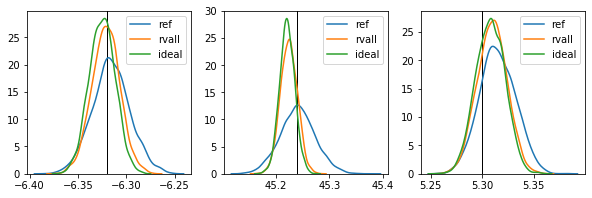

In [5]:
fig, ax = plt.subplots(1, 3, figsize=(10, 3))
for k, v in azfit.items():
    for i, cax in enumerate(ax):
        sns.kdeplot(v.posterior["v0"].stack(i=('chain','draw'))[i], ax=cax, label=k)

for truth, cax in zip([-6.32, 45.24, 5.30], ax):
    cax.axvline(truth, c='k', lw=1, zorder=-5)

In [9]:
from IPython.display import display, HTML
var_names = list(azfit['ref'].posterior.data_vars.keys())
var_names.remove('probmem')
with pd.option_context("display.max_rows", 100):
    display(HTML(az.summary(azfit['ref'], var_names).to_html()))

/home/soh/.conda/envs/nitro/lib/python3.7/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
v0[0],-6.316,0.020,-6.352,-6.279,0.000,0.000,1613.0,1613.0,1610.0,2395.0,1.0
v0[1],45.241,0.033,45.175,45.298,0.001,0.001,1651.0,1651.0,1659.0,1876.0,1.0
v0[2],5.315,0.017,5.283,5.347,0.000,0.000,2007.0,2007.0,2009.0,2673.0,1.0
sigv[0],0.301,0.023,0.258,0.345,0.001,0.000,1206.0,1206.0,1247.0,1576.0,1.0
sigv[1],0.184,0.062,0.065,0.299,0.002,0.001,889.0,889.0,901.0,731.0,1.0
sigv[2],0.309,0.021,0.271,0.346,0.001,0.000,1339.0,1339.0,1369.0,1735.0,1.0
"Omega[0,0]",1.000,0.000,1.000,1.000,0.000,0.000,4000.0,4000.0,4000.0,4000.0,NaN
"Omega[0,1]",0.244,0.260,-0.255,0.733,0.008,0.005,1197.0,1197.0,1201.0,1732.0,1.0
"Omega[0,2]",0.201,0.094,0.023,0.366,0.003,0.002,1061.0,1061.0,1142.0,1512.0,1.0
"Omega[1,0]",0.244,0.260,-0.255,0.733,0.008,0.005,1197.0,1197.0,1201.0,1732.0,1.0


In [91]:
fitlist = [
    kn.load_stanfit('../report/hyades-mock-fullmodel/fit2.pickle'),
    kn.load_stanfit('../report/hyades-mock-fullmodel/fit.pickle'),
    kn.load_stanfit('../report/hyades-dr2/fit.pickle')
]

# fit = kn.load_stanfit('../report/hyades-mock-fullmodel/fit1.pickle')

In [4]:
%run utils.ipynb

In [10]:
fit.data['Nrv']

56

In [1]:
fit = kn.load_stanfit('../report/hyades-mock-fullmodel/fit.pickle')
# fit = kn.load_stanfit('../report/hyades-mock-fullmodel/fit_harpsrv.pickle')
# fit = kn.load_stanfit('../report/hyades-mock-fullmodel/fit_sigv0.6.pickle')
# fit = kn.load_stanfit('../report/hyades-dr2/fit.pickle')

with plt.style.context(mystyledict):
    fig = plt.figure(figsize=(6, 6), constrained_layout=True)
    gs = fig.add_gridspec(3, 2)
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[1, 0])
    ax3 = fig.add_subplot(gs[2, 0])
    ax4 = fig.add_subplot(gs[:, 1])

    pars = ['v0','sigv','T_param']
    truths = np.array([0.3, 0.3, 0.3,-6.32, 45.24, 5.30, ])

    dd = (
        fit.to_dataframe(['v0'], diagnostics=False).iloc[:,3:].values
        - np.array([-6.32, 45.24, 5.30])[None])
    ax1.violinplot(
        dd,
        positions=np.r_[1:4:1],
        vert=False, showextrema=False
    )
    ax1.set_yticks([1,2,3])
    ax1.set_yticklabels(['$v_{0,x}$', '$v_{0,y}$', '$v_{0,z}$'][::-1])
    ax1.set_xlabel(r'$\rm km\,\rm s^{-1}$')
    ax1.set_title('mean velocity')
    ax1.set_xlim([-0.15,0.15])

    dd = (
        fit.to_dataframe(['sigv'], diagnostics=False).iloc[:,3:].values
        - np.array([0.6,0.6,0.6])[None])
    ax2.violinplot(
        dd,
        positions=np.r_[1:4:1],
        vert=False, showextrema=False
    )
    ax2.set_yticks([1,2,3])
    ax2.set_yticklabels(['$\sigma_{v,x}$', '$\sigma_{v,y}$', '$\sigma_{v,z}$'])
    ax2.set_xlabel(r'$\rm km\,\rm s^{-1}$')
    ax2.set_title('scale of $\Sigma$')
    ax2.set_xlim([-0.35,0.35])

    dd = (
        fit.to_dataframe('Omega', diagnostics=False).iloc[:,[4,5,8]].values
        - np.array([0,0,0])[None])
    ax3.violinplot(
        dd,
        positions=np.r_[1:4:1],
        vert=False, showextrema=False
    )
    ax3.set_yticks([1,2,3])
    ax3.set_yticklabels(['$\Omega_{xy}$', '$\Omega_{xz}$', '$\Omega_{yz}$'])
    ax3.set_title('correlation of $\Sigma$')
    ax3.set_xlim(-1,1)

    dd = (
        fit.to_dataframe('T_param', diagnostics=False).iloc[:,3:].values
        - np.array([0]*9)[None])
    ax4.violinplot(
        dd,
        positions=np.r_[1:10:1],
        vert=False, showextrema=False
    )
    ax4.set_yticks(np.arange(1,10))
    ax4.set_yticklabels(['11','12','13','21','22','23','31','32','33'])
    ax4.set_xlabel(r'$\rm m\,\rm s^{-1}\,\rm pc^{-1}$')
    ax4.set_title('velocity gradient $\mathbf {T}_{ij}$')
    ax4.set_xlim(-50,50)

    for cax in fig.axes:
        cax.axvline(0, c='k')
# fig.savefig('mock_hyades_dr2_null.pdf')

NameError: name 'kn' is not defined

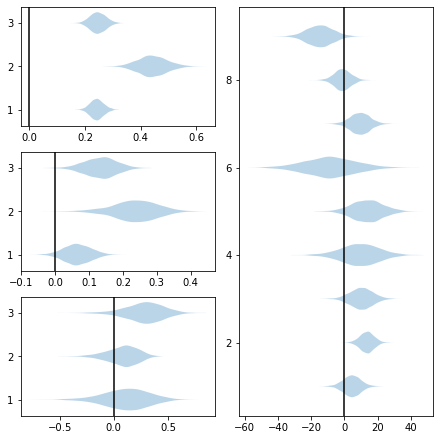

In [82]:
fit = kn.load_stanfit('../report/hyades-dr2/fit.pickle')

fig = plt.figure(figsize=(6, 6), constrained_layout=True)
gs = fig.add_gridspec(3, 2)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[2, 0])
ax4 = fig.add_subplot(gs[:, 1])

pars = ['v0','sigv','T_param']
truths = np.array([0.3, 0.3, 0.3,-6.32, 45.24, 5.30, ])

dd = (
    fit.to_dataframe(['v0'], diagnostics=False).iloc[:,3:].values
    - np.array([-6.32, 45.24, 5.30])[None])
ax1.violinplot(
    dd,
    positions=np.r_[3:0:-1],
    vert=False, showextrema=False
)


dd = (
    fit.to_dataframe(['sigv'], diagnostics=False).iloc[:,3:].values
    - np.array([0.3,0.3,0.3])[None])
ax2.violinplot(
    dd,
    positions=np.r_[3:0:-1],
    vert=False, showextrema=False
)

dd = (
    fit.to_dataframe('Omega', diagnostics=False).iloc[:,[4,5,8]].values
    - np.array([0,0,0])[None])
ax3.violinplot(
    dd,
    positions=np.r_[3:0:-1],
    vert=False, showextrema=False
)

dd = (
    fit.to_dataframe('T_param', diagnostics=False).iloc[:,3:].values
    - np.array([0]*9)[None])
ax4.violinplot(
    dd,
    positions=np.r_[9:0:-1],
    vert=False, showextrema=False
)

for cax in fig.axes:
    cax.axvline(0, c='k')

In [327]:
az.summary(azfit['ref'], ['sigv', 'Omega',])

/data/vault/soh/projects/opensource/arviz/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
sigv[0],0.301,0.023,0.258,0.345,0.001,0.000,1206.0,1206.0,1247.0,1576.0,1.0
sigv[1],0.184,0.062,0.065,0.299,0.002,0.001,889.0,889.0,901.0,731.0,1.0
sigv[2],0.309,0.021,0.271,0.346,0.001,0.000,1339.0,1339.0,1369.0,1735.0,1.0
"Omega[0,0]",1.000,0.000,1.000,1.000,0.000,0.000,4000.0,4000.0,4000.0,4000.0,NaN
"Omega[0,1]",0.244,0.260,-0.255,0.733,0.008,0.005,1197.0,1197.0,1201.0,1732.0,1.0
"Omega[0,2]",0.201,0.094,0.023,0.366,0.003,0.002,1061.0,1061.0,1142.0,1512.0,1.0
"Omega[1,0]",0.244,0.260,-0.255,0.733,0.008,0.005,1197.0,1197.0,1201.0,1732.0,1.0
"Omega[1,1]",1.000,0.000,1.000,1.000,0.000,0.000,4000.0,4000.0,3574.0,3378.0,1.0
"Omega[1,2]",0.119,0.288,-0.381,0.698,0.008,0.006,1303.0,1303.0,1288.0,1458.0,1.0
"Omega[2,0]",0.201,0.094,0.023,0.366,0.003,0.002,1061.0,1061.0,1142.0,1512.0,1.0


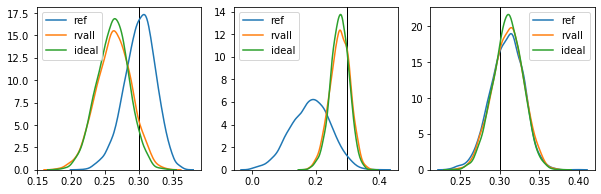

In [71]:
fig, ax = plt.subplots(1, 3, figsize=(10, 3))
for k, v in azfit.items():
    for i, cax in enumerate(ax):
        sns.kdeplot(v.posterior["sigv"].stack(i=('chain','draw'))[i], ax=cax, label=k)

for truth, cax in zip([.3,.3,.3], ax):
    cax.axvline(truth, c='k', lw=1, zorder=-5)

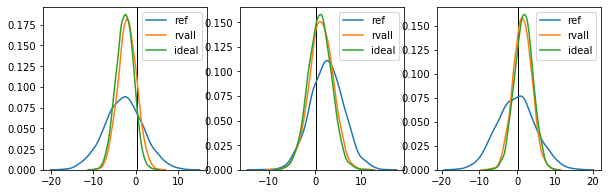

In [72]:
fig, ax = plt.subplots(1, 3, figsize=(10, 3))
for k, v in azfit.items():
    for name, cax in zip(['omegax','omegay','omegaz'],ax):
        sns.kdeplot(v.posterior[name].stack(i=('chain','draw')), ax=cax, label=k)

for truth, cax in zip([.3,.3,.3], ax):
    cax.axvline(truth, c='k', lw=1, zorder=-5)

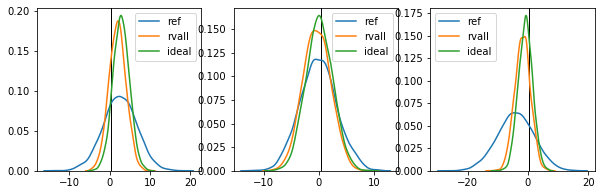

In [73]:
fig, ax = plt.subplots(1, 3, figsize=(10, 3))
for k, v in azfit.items():
    for name, cax in zip(['w1','w2','w3'],ax):
        sns.kdeplot(v.posterior[name].stack(i=('chain','draw')), ax=cax, label=k)

for truth, cax in zip([.3,.3,.3], ax):
    cax.axvline(truth, c='k', lw=1, zorder=-5)

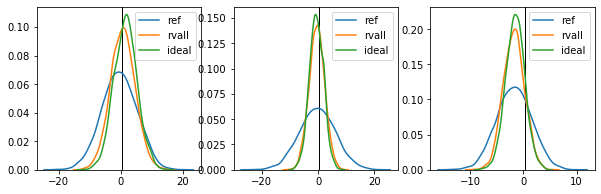

In [74]:
fig, ax = plt.subplots(1, 3, figsize=(10, 3))
for k, v in azfit.items():
    for name, cax in zip(['w4','w5','kappa'],ax):
        sns.kdeplot(v.posterior[name].stack(i=('chain','draw')), ax=cax, label=k)

for truth, cax in zip([.3,.3,.3], ax):
    cax.axvline(truth, c='k', lw=1, zorder=-5)

In [75]:
az.summary(azfit['ideal'],'sigv')

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
sigv[0],0.262,0.023,0.217,0.304,0.001,0.000,1352.0,1352.0,1354.0,2021.0,1.0
sigv[1],0.276,0.029,0.222,0.329,0.001,0.001,1132.0,1132.0,1134.0,1580.0,1.0
sigv[2],0.310,0.019,0.273,0.342,0.000,0.000,1382.0,1382.0,1382.0,1959.0,1.0


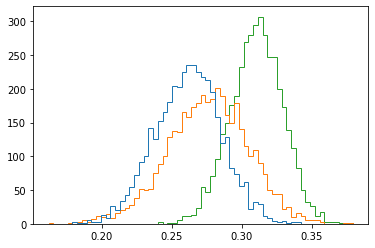

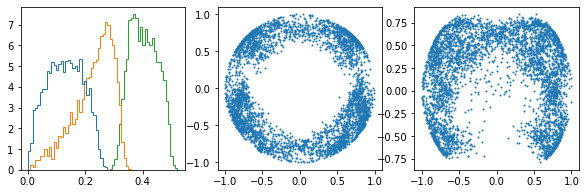

In [109]:
fig, ax = plt.subplots()
ax.hist(azfit['ideal'].posterior['sigv'].stack(i=('chain','draw')).values.T, histtype='step', bins=64);

scales = azfit['ideal'].posterior['sigv'].stack(i=('chain','draw')).values.T
import scipy as sp
x1= np.random.uniform(0, 3, len(scales))
x2= np.random.uniform(0, 3-x1, len(scales))
random_eigv = np.array([[xx1, xx2, 3-xx1-xx2] for xx1, xx2 in zip(x1, x2)])
corr = [sp.stats.random_correlation.rvs(e) for e in random_eigv]

outw, outv=[],[]
for i in range(4000):
    Omega = corr[i]
    sigv = scales[i]

    this = np.diag(sigv) @ Omega @ np.diag(sigv)
    w,v = np.linalg.eig(this)

    outw.append(w)
    outv.append(v)
i_wsort = np.argsort(outw, axis=1)
# my numpy-fu running out...
sorted_v = np.stack([outv[j][:,i] for j, i in enumerate(i_wsort)])
sorted_w = np.sort(outw, axis=1)

# plt.hist(sorted_w, histtype='step',bins=64,density=True);
fig, ax = plt.subplots(1, 3, figsize=(10,3))
ax[0].hist(np.sqrt(sorted_w), density=True, bins=64, histtype='step');
for i in range(1):
    ax[1].scatter(sorted_v[:,0,i], sorted_v[:,1,i],s=1);
    ax[2].scatter(sorted_v[:,0,i], sorted_v[:,2,i],s=1);

In [361]:
outw, outv=[],[]
for i in range(4000):
    Omega = azfit['ideal'].posterior['Omega'].stack(samples=["chain", "draw"]).values[:,:,i]
    sigv = azfit['ideal'].posterior['sigv'].stack(samples=["chain", "draw"]).values[:,i]

    this = np.diag(sigv) @ Omega @ np.diag(sigv)
    w,v = np.linalg.eig(this)

    outw.append(w)
    outv.append(v)

In [362]:
i_wsort = np.argsort(outw, axis=1)
# my numpy-fu running out...
sorted_v = np.stack([outv[j][:,i] for j, i in enumerate(i_wsort)])
sorted_w = np.sort(outw, axis=1)

In [364]:
pd.DataFrame(np.sqrt(sorted_w)).describe()

,0,1,2
count,4000.000000,4000.000000,4000.000000
mean,0.219535,0.281193,0.336821
std,0.031573,0.012705,0.021778
min,0.071542,0.244461,0.278106
25%,0.200214,0.271983,0.320752
50%,0.224054,0.281168,0.335694
75%,0.243793,0.290281,0.351260
max,0.284378,0.321853,0.425249


In [359]:
np.mean(sorted_w,axis=0),np.std(sorted_w,axis=0)

(array([0.21953514, 0.28119335, 0.33682145]),
 array([0.03156873, 0.0127034 , 0.02177536]))

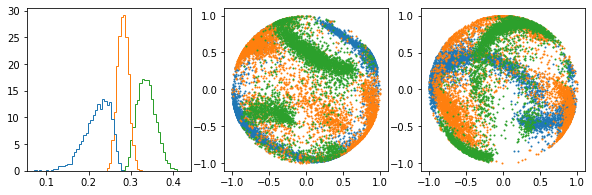

In [363]:
# plt.hist(sorted_w, histtype='step',bins=64,density=True);
fig, ax = plt.subplots(1, 3, figsize=(10,3))
ax[0].hist(np.sqrt(sorted_w), density=True, bins=64, histtype='step');
for i in range(3):
    ax[1].scatter(sorted_v[:,0,i], sorted_v[:,1,i],s=1);
    ax[2].scatter(sorted_v[:,0,i], sorted_v[:,2,i],s=1);

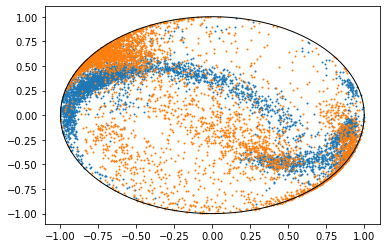

In [241]:
plt.scatter(sorted_v[:,0,0], sorted_v[:,2,0], s=1)
plt.scatter(sorted_v[:,0,1], sorted_v[:,1,1], s=1)
theta=np.linspace(0,2*np.pi,101)
plt.plot(np.cos(theta), np.sin(theta), c='k', lw=1)

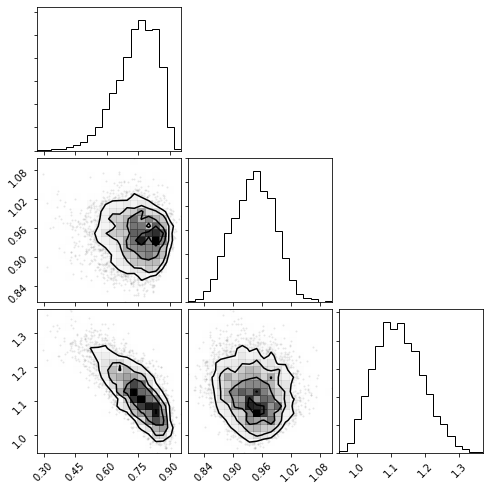

In [201]:
fig = corner(out)
# corner(out1, fig=fig, color='r', truths=[0.3,0.3,0.3]);

In [88]:
np.sqrt(np.linalg.eig(this)[0])

array([0.17988992, 0.28464862, 0.37684964])

In [342]:
dd = pd.DataFrame({
    'ra':fit_ideal.data['ra'],
    'dec':fit_ideal.data['dec'],
    'parallax':fit_ideal.data['a'][:,0],
    'pmra':fit_ideal.data['a'][:,1],
    'pmdec':fit_ideal.data['a'][:,2]
})
dd.loc[fit_ideal.data['irv'], 'radial_velocity'] = fit_ideal.data['rv']

In [338]:
np.where(np.exp(fit['probmem']).mean(axis=0)<.5)[0]

array([463, 464, 465, 466, 467, 468, 469, 470, 471, 472, 473, 474, 475,
       476, 477, 478, 479, 480, 481, 482, 483, 484, 485, 486, 487, 488,
       489, 490, 491, 492, 493, 494, 495, 496, 497, 498, 499, 500, 501,
       502, 503, 504, 505, 506, 507, 508, 509, 510, 511, 512, 513, 514])

In [339]:
pd.Series(fit.data['rv_error'][fit.data['irv']>463]).describe()

count    20.000000
mean      0.519504
std       0.397063
min       0.144171
25%       0.304582
50%       0.466385
75%       0.570052
max       2.034189
dtype: float64

In [343]:
vx,vy,vz = dd.g.icrs.velocity.d_xyz

In [344]:
np.nanstd(vx[:-52]), np.nanstd(vy[:-52]), np.nanstd(vz[:-52])

(<Quantity 0.28107059 km / s>,
 <Quantity 0.30099737 km / s>,
 <Quantity 0.2981595 km / s>)

In [141]:
np.std(vx[-52:]), np.std(vy[-52:]), np.std(vz[-52:])

(<Quantity 18.36480651 km / s>,
 <Quantity 21.67708012 km / s>,
 <Quantity 18.44422518 km / s>)

In [58]:
np.diag(sigv) @ Omega @ np.diag(sigv)

array([[ 0.05356482, -0.02554704,  0.01239889],
       [-0.02554704,  0.07652035,  0.01837453],
       [ 0.01239889,  0.01837453,  0.10606442]])

In [56]:
sigv

array([0.23144075, 0.27662312, 0.32567532])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe331702ef0>,
      dtype=object)

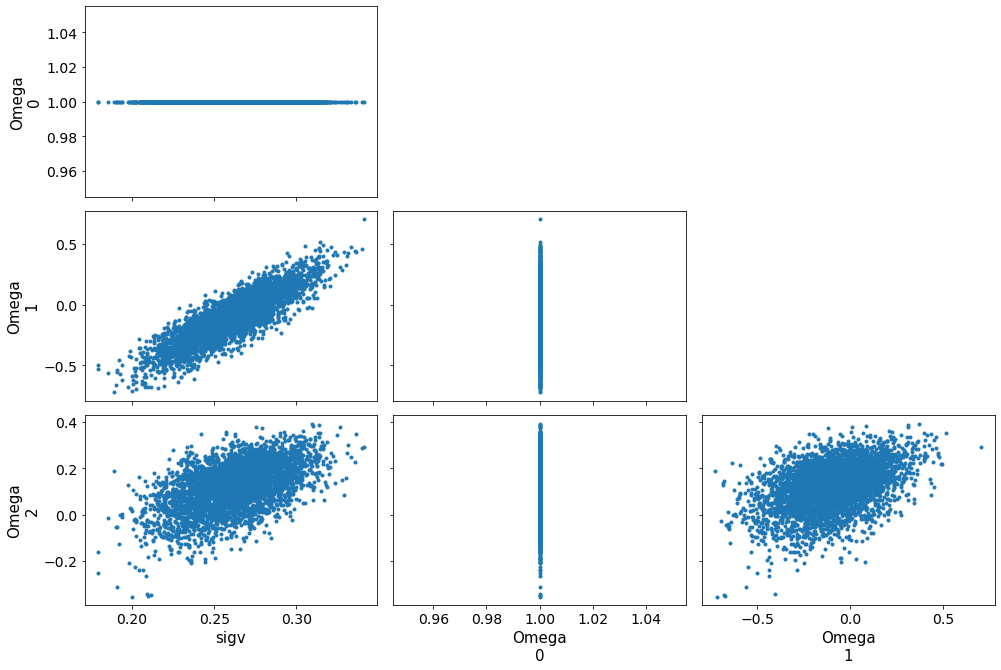

In [47]:
az.plot_pair(
    azfit["ideal"],
    var_names=["sigv", "Omega"],
    coords={"sigv_dim_0": 0, 'Omega_dim_0':0},
)

In [109]:
az.summary(azfit, var_names=['v0','sigv','Omega','T_param','v0_bg','sigv_bg','f_mem'])

/data/vault/soh/projects/opensource/arviz/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
v0[0],-6.316,0.020,-6.354,-6.279,0.000,0.000,1906.0,1906.0,1914.0,2353.0,1.00
v0[1],45.240,0.034,45.178,45.307,0.001,0.001,1914.0,1913.0,1934.0,2223.0,1.00
v0[2],5.315,0.018,5.283,5.349,0.000,0.000,2400.0,2399.0,2404.0,2477.0,1.00
sigv[0],0.302,0.023,0.258,0.343,0.001,0.000,1343.0,1343.0,1357.0,2172.0,1.00
sigv[1],0.185,0.060,0.074,0.292,0.002,0.001,1406.0,1406.0,1392.0,1723.0,1.00
sigv[2],0.308,0.020,0.270,0.345,0.001,0.000,1520.0,1520.0,1530.0,2400.0,1.00
"Omega[0,0]",1.000,0.000,1.000,1.000,0.000,0.000,4000.0,4000.0,4000.0,4000.0,NaN
"Omega[0,1]",0.254,0.257,-0.219,0.732,0.007,0.005,1358.0,1358.0,1350.0,1954.0,1.00
"Omega[0,2]",0.202,0.091,0.027,0.361,0.003,0.002,1154.0,1154.0,1185.0,1994.0,1.00
"Omega[1,0]",0.254,0.257,-0.219,0.732,0.007,0.005,1358.0,1358.0,1350.0,1954.0,1.00


In [27]:
x, y, z = df.g.icrs.cartesian.xyz
N = x.size
newicrs = coords.ICRS(
    x=x,
    y=y,
    z=z,
    v_x=(np.zeros(N)) * u.km / u.s,
    v_y=np.zeros(N) * u.km / u.s,
    v_z=(np.ones(N)) * u.km / u.s,
    representation_type='cartesian',
    differential_type='cartesian'
)

x-ra, y-rv, z-dec

/home/soh/.conda/envs/flatwhite/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/home/soh/.conda/envs/flatwhite/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


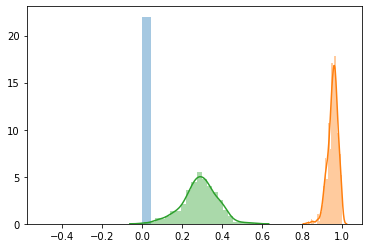

In [28]:
vra=(newicrs.spherical.differentials['s'].d_lon*newicrs.spherical.distance).to(u.km/u.s, u.equivalencies.dimensionless_angles())
vdec=(newicrs.spherical.differentials['s'].d_lat*newicrs.spherical.distance).to(u.km/u.s, u.equivalencies.dimensionless_angles())
vr=newicrs.spherical.differentials['s'].d_distance
sns.distplot(vra)
sns.distplot(vdec)
sns.distplot(vr)

In [25]:
df_rv=df.groupby(df['radial_velocity'].notna()).get_group(True)

In [29]:
cr = np.linalg.norm(df.g.icrs.cartesian.xyz, axis=0)

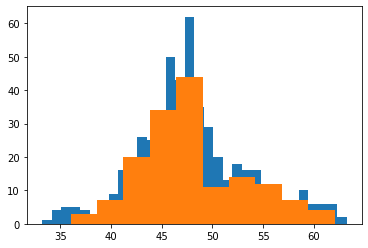

In [38]:
plt.hist(cr, 32);
plt.hist(cr[df['radial_velocity'].notna()]);

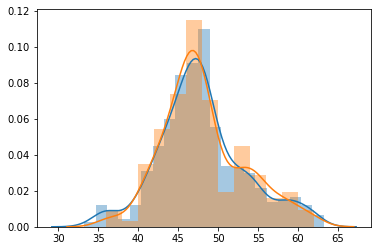

In [33]:
sns.distplot(cr)
sns.distplot(cr[df['radial_velocity'].notna()])

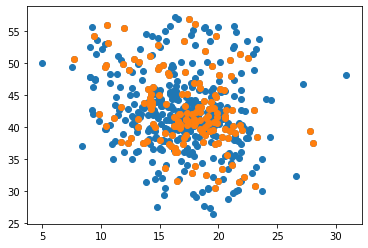

In [26]:
plt.scatter(df.g.icrs.cartesian.x,df.g.icrs.cartesian.y)
plt.scatter(df_rv.g.icrs.cartesian.x, df_rv.g.icrs.cartesian.y)

In [10]:
N=3
newicrs = coords.ICRS(
    x=[18.86473835, 21.67970908, 20.72973286]*u.pc,
    y=[40.22548926, 37.86070217, 35.62720777]*u.pc,
    z=[17.72885924, 14.33914541, 15.35224482]*u.pc,
    v_x=np.zeros(N) * u.km / u.s,
    v_y=np.ones(N) * u.km / u.s,
    v_z=np.zeros(N) * u.km / u.s,
    representation_type='cartesian',
    differential_type='cartesian'
)
newicrs.spherical.differentials['s']

<SphericalDifferential (d_lon, d_lat, d_distance) in (mas / yr, mas / yr, km / s)
    [(2.01599364, -1.4797259 , 0.8409045 ),
     (2.40265952, -1.24460911, 0.82441304),
     (2.57379428, -1.44682789, 0.80997892)]>

In [8]:
import astropy.coordinates as coords
import astropy.units as u
import numpy as np

In [3]:
N=1
newicrs = coords.ICRS(
    x=18.*u.pc,
    y=40.*u.pc,
    z=17.*u.pc,
    v_x=0 * u.km / u.s,
    v_y=1 * u.km / u.s,
    v_z=0 * u.km / u.s,
    representation_type='cartesian',
    differential_type='cartesian'
)
newicrs.spherical.differentials['s']

<SphericalDifferential (d_lon, d_lat, d_distance) in (mas / yr, mas / yr, km / s)
    (1.97354027, -1.47775868, 0.85029433)>

In [94]:
plt.style.use('smoh')

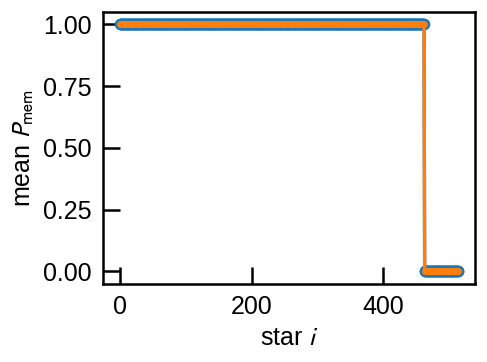

In [81]:
fig, ax = plt.subplots(figsize=(4,3))
ax.plot(data['mem'],'o-', label='truth')
ax.plot(np.mean(np.exp(fit['probmem']), axis=0), '.-', label='inferred')
ax.set_xlabel('star $i$')
ax.set_ylabel('mean $P_\mathrm{mem}$');

/data/vault/soh/projects/opensource/arviz/arviz/plots/kdeplot.py:413: RuntimeWarning: invalid value encountered in sqrt
  std_devs = np.diag(cov ** 0.5)


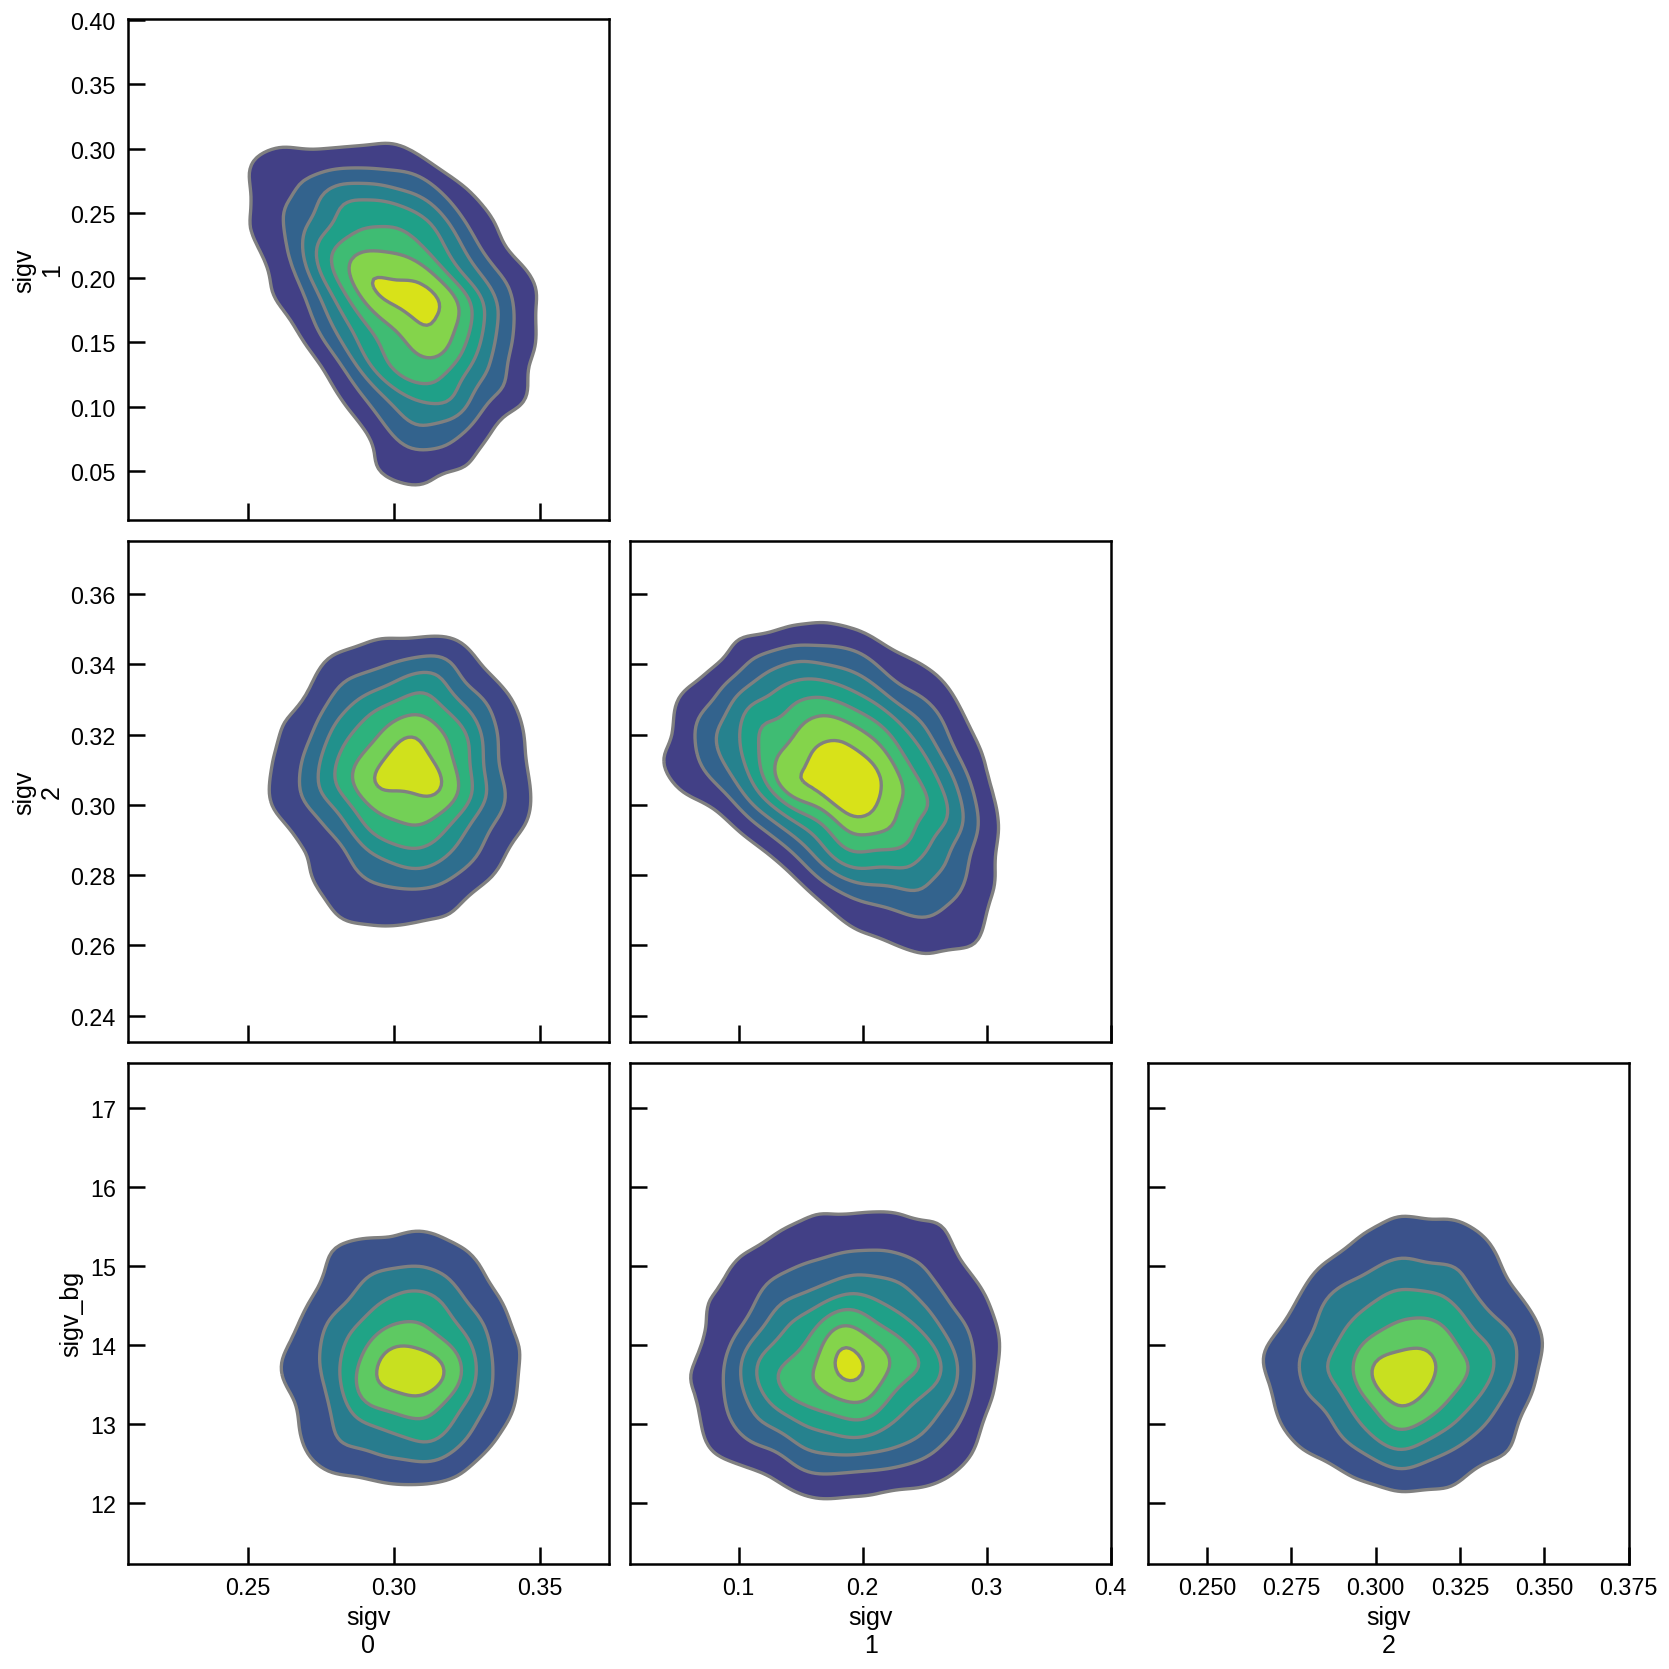

In [95]:
az.plot_pair(azfit, var_names=['sigv', 'sigv_bg'], kind='kde', fill_last=False);

In [26]:
data['x'], data['y'], data['z'] = data.g.icrs.cartesian.xyz.value
data['vx'], data['vy'], data['vz'] = data.g.icrs.velocity.d_xyz.value

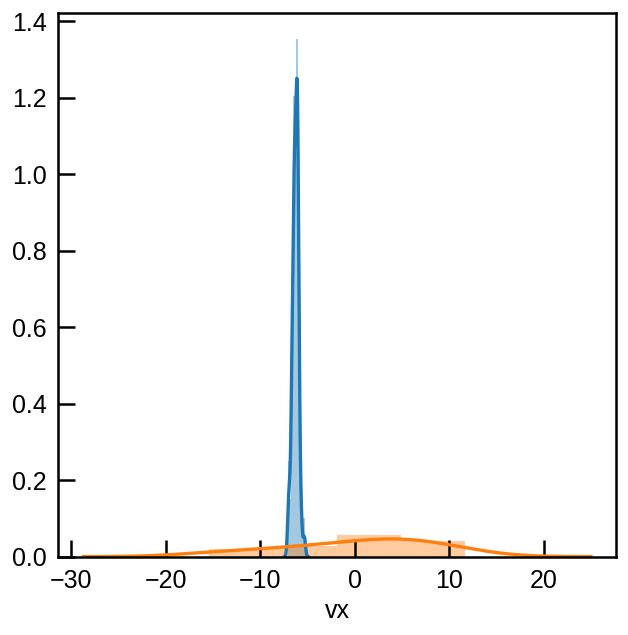

In [27]:
grp = data.groupby('mem')
sns.distplot(grp.get_group(1)['vx'].dropna())
sns.distplot(grp.get_group(0)['vx'].dropna())